# Overview 

This notebook is designed to help you understand the limitations and pitfalls of explanations & introduce you to available evaluation metrics you can use to numerically evaluate the quality of the LIME explanation on a tabular dataset.
The metrics we will use in this notebook are: 
1. Stability
2. Adherence - R Square
3. Faithfulness
4. Monotonity

#Stability
One of the issues of the existing locally interpretable models
is lack of “stability”. Lack of stability refers to small or no changes to the input resulting in large changes to the output. In the context of post-hoc explanations this refers to obtaining the same feature importance for the same instance if we run the post-hoc explainers multiple times. 

Measures of stability include average Jaccard similarity and Pearson’s correlation among all pairs of feature subsets. This notebook will show that if you run LIME repeatedly on the same instance with the same classifier model you will get different explanations. The stability metric in this notebook meassures the level of variation in LIME explanations and the metric ranges from 0 to 1 (0 means similar, 1 means highly dissimilar). The value closer to 0 means the explanations are less unstable. For more details refer to DLIME (https://arxiv.org/pdf/1906.10263.pdf).


# Adherence - R-Square
https://blog.minitab.com/blog/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit#:~:text=R%2Dsquared%20is%20a%20statistical,multiple%20determination%20for%20multiple%20regression.&text=100%25%20indicates%20that%20the%20model,response%20data%20around%20its%20mean

# Faithfullness

"This metric evaluates the correlation between the importance assigned by the interpretability algorithm to attributes and the effect of each of the attributes on the performance of the predictive model. The higher the importance, the higher should be the effect, and vice versa, The metric evaluates this by incrementally removing each of the attributes deemed important by the interpretability metric, and evaluating the effect on the performance, and then calculating the correlation between the 
weights (importance) of the attributes and corresponding model performance."

Reference:
David Alvarez Melis and Tommi Jaakkola. Towards robust interpretability with self-explaining neural networks. In S. Bengio, H. Wallach, H. Larochelle, K. Grauman, N. Cesa-Bianchi, and R. Garnett, editors, Advances in Neural Information Processing Systems 31, pages 7775-7784. 2018.

https://papers.nips.cc/paper/8003-towards-robust-interpretability-with-self-explaining-neural-networks.pdf


# Monotonicity
"This metric measures the effect of individual features on model performance by evaluating the effect on model performance of incrementally adding each attribute in order of increasing importance. As each feature is added, the performance of the model should correspondingly increase, thereby resulting in monotonically increasing model performance."

Reference:
Ronny Luss, Pin-Yu Chen, Amit Dhurandhar, Prasanna Sattigeri, Karthikeyan Shanmugam, and Chun-Chen Tu. Generating Contrastive Explanations with Monotonic Attribute Functions. CoRR abs/1905.13565. 2019.

https://arxiv.org/pdf/1905.12698.pdf

# Variables Stability Index (VSI) & Coefficients Stability Index (CSI): 

**Variables Stability Index (VSI)**
Measures whether the variables in the repeated LIME explanations are the same

**Coefficients Stability Index (CSI)** 
Checks whether the coefficients are the same in the different LIMEs

Video Presentation
https://www.youtube.com/watch?v=HCDkMM0vq0E&feature=youtu.be

Paper
https://arxiv.org/pdf/2006.05714.pdf

Source Code
https://github.com/giorgiovisani/LIME_stability

# LIME Numertic Metrics Evaluations

In [ ]:
!pip install aix360
!pip install lime-stability
!pip install lime

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

#from explainer_tabular import LimeTabularExplainer
import lime
import lime.lime_tabular
from lime_stability.stability import LimeTabularExplainerOvr

#from load_dataset import LoadDataset

from sklearn.datasets import load_breast_cancer
RANDOM_SEED = 426

In [ ]:
cancer_data = load_breast_cancer()
X = cancer_data.data
feature_names = cancer_data.feature_names
target_names = cancer_data.target_names

train, test, labels_train, labels_test = train_test_split(cancer_data.data, cancer_data.target, train_size=0.80)

In [ ]:
rf = RandomForestClassifier(n_estimators=10, random_state=0, max_depth=5, max_features=5)
rf.fit(train, labels_train)
mean_accuracy = rf.score(test, labels_test)

explainer = lime.lime_tabular.LimeTabularExplainer(train,
                                 mode="classification",
                                 feature_names=feature_names,
                                 class_names=target_names,
                                 discretize_continuous=True,
                                 verbose=False)

# Compute the Stability of the explanations

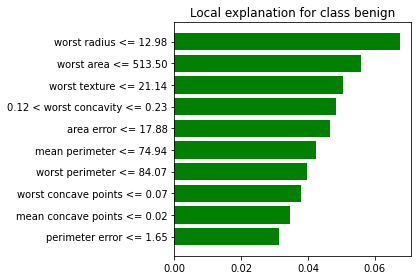

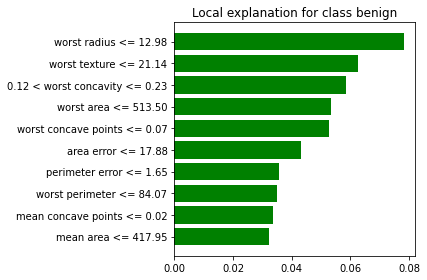

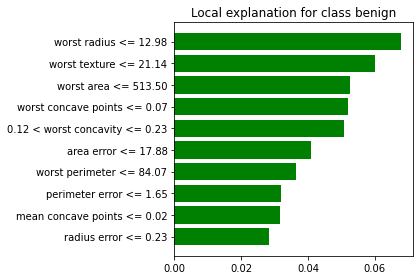

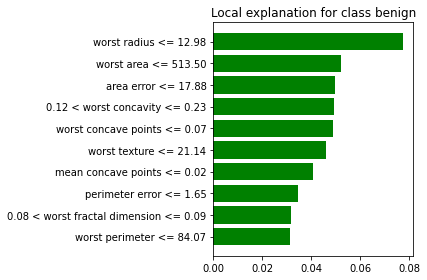

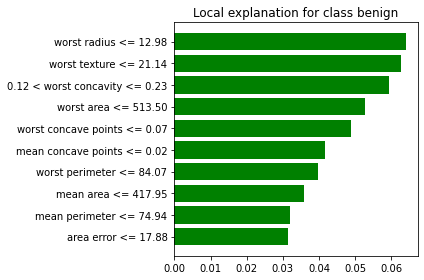

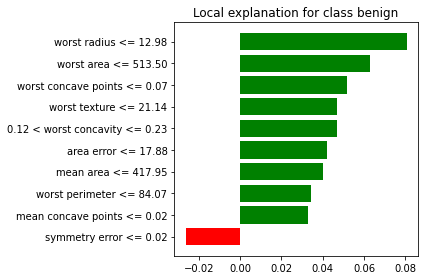

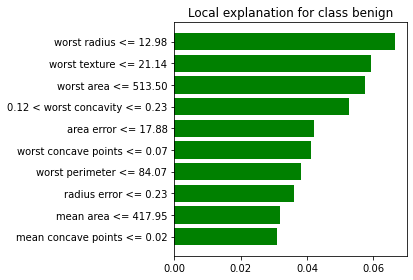

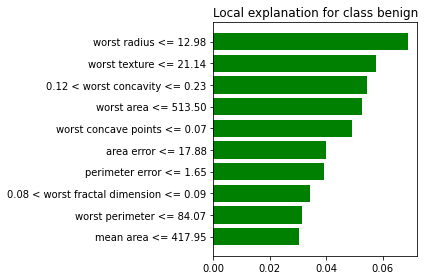

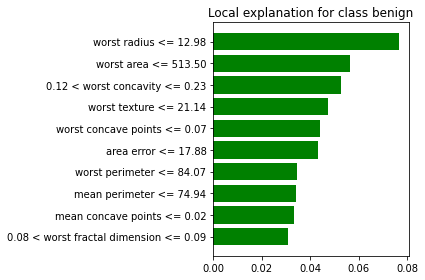

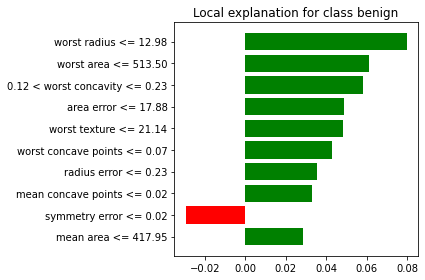

In [ ]:

def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))


def jaccard_distance(usecase):
    sim = []
    for l in usecase:
        i_sim = []
        for j in usecase:
            i_sim.append(1-jaccard_similarity(l, j))
        sim.append(i_sim)
    return sim


for x in range(0, 1):
    use_case_three_features = []

    for i in range(0, 10):
        exp_lime = explainer.explain_instance(test[x],
                                             rf.predict_proba,
                                             num_features=10,
                                             labels=(0,1))
        
        list_feature = []

        exp_lime.as_pyplot_figure()
        plt.tight_layout()

        r_features = exp_lime.as_list()

        for feature in r_features:
          list_feature.append(feature[0])
        use_case_three_features.append(list_feature)

0.24662004662004658


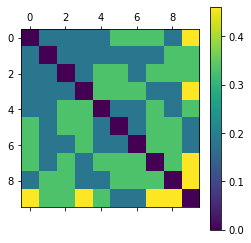

In [ ]:
################################################
sim = jaccard_distance(use_case_three_features)
#np.savetxt("results/rf_lime_jdist_bc.csv", sim, delimiter=",")
print(np.asarray(sim).mean())

plt.matshow(sim);
plt.colorbar()
#plt.savefig("results/sim_use_case_3.pdf", bbox_inches='tight')
plt.show()

# Compute Adherence - R Square

In [ ]:
#exp_lime.score
r_squared_total = []
for idx in range(0,test.shape[0]):
  exp = explainer.explain_instance(test[idx],
                                 rf.predict_proba,
                                 num_features=10,
                                 labels=(0,1))
  r_squared_total.append(exp.score)
print ("R Squared = ", np.mean(r_squared_total))

R Squared =  0.16610615798481257


# Computes the Monotonicity and Faithfulness of the explanations

In [ ]:
idx = 0

exp = explainer.explain_instance(test[idx],
                                 rf.predict_proba,
                                 num_features=10,
                                 labels=(0,1))

from aix360.metrics import faithfulness_metric, monotonicity_metric

predicted_class = rf.predict(test[idx].reshape(1,-1))[0]
le = exp.local_exp[predicted_class]

m = exp.as_map()

x = test[idx]
coefs = np.zeros(x.shape[0])

for v in le:
    coefs[v[0]] = v[1]


base = np.zeros(x.shape[0])


print("Faithfulness: ", faithfulness_metric(rf, x, coefs, base))
print("Monotonity: ", monotonicity_metric(rf, x, coefs, base))

Faithfulness:  -0.12340912468590895
Monotonity:  True


# Compute Variables Stability Index (VSI) & Coefficients Stability Index (CSI): 

In [ ]:
explainer = LimeTabularExplainerOvr(train, 
                                    feature_names=feature_names, 
                                    class_names=target_names, 
                                    verbose=True, 
                                    mode='classification')

In [ ]:
idx = 0

params = {"data_row": test[idx],
          "predict_fn": rf.predict_proba,
          "num_samples": 1000,
          "num_features": 10,
          "distance_metric": "euclidean",
          "labels": (0,1)}

exp = explainer.explain_instance(**params)

Intercept 0.5357142190236491
Prediction_local [0.11505341]
Right: 0.001999515855725006
Intercept 0.46428578097635104
Prediction_local [0.88494659]
Right: 0.9980004841442749


In [ ]:
csi, vsi = explainer.check_stability(n_calls=10,**params,index_verbose=True)
print("CSI: ",csi,"\nVSI: ",vsi,"\n")

Percentage of overlapping confidence intervals, variable mean radius: 100.0%

Percentage of overlapping confidence intervals, variable worst texture: 100.0%

Percentage of overlapping confidence intervals, variable worst fractal dimension: 100.0%

Percentage of overlapping confidence intervals, variable mean concave points: 100.0%

Percentage of overlapping confidence intervals, variable mean area: 100.0%

Percentage of overlapping confidence intervals, variable worst concave points: 100.0%

Percentage of overlapping confidence intervals, variable perimeter error: 100.0%

Percentage of overlapping confidence intervals, variable worst radius: 100.0%

Percentage of overlapping confidence intervals, variable worst perimeter: 100.0%

Percentage of overlapping confidence intervals, variable worst area: 100.0%

Percentage of overlapping confidence intervals, variable radius error: 100.0%

Percentage of overlapping confidence intervals, variable worst concavity: 100.0%

Percentage of overlapp